In [159]:
import networkx as nx
from wordcloud import WordCloud
from PIL import Image
from colour import Color
import pandas as pd
import re
import numpy as np
import io
import nltk

## Loading in data

In [21]:
df = pd.read_csv('starwarscharacters.csv')

## Building the graph

In [22]:
G = nx.DiGraph()

for i in range(len(df)):
    name = df.loc[i]['name']
    species = df.loc[i]['species']
    goodness = df.loc[i]['goodness']
    G.add_node(name, goodness=goodness, species=species)

for i in range(len(df)):
    name = df.loc[i]['name']
    fileName = name.replace(" ", "_") + ".txt"
    text = open("./Wookiepediafiles/" + fileName, "r").read()
    links = re.findall('\[\[(.*?)\]\]', text)
    for link in links:
        for l in link.split("|"):
            if l in list(df['name']):
                if G.has_edge(name, l):
                    # If edge already exists, increase weight of it by 1
                    G[name][l]['weight'] += 1.0
                else:
                    G.add_edge(name, l)
                    G[name][l]['weight'] = 1
                break
    #f.close()

print("Amount of nodes: %s" % G.number_of_nodes())
print("Amount of edges: %s" % G.number_of_edges())

Amount of nodes: 407
Amount of edges: 5100


# Plotting the graph

In [131]:
# Draw network
%matplotlib inline
from fa2 import ForceAtlas2
import matplotlib
import matplotlib.pyplot as plt

G_undir = G.to_undirected()

# set up forceatlas2 parameters
forceatlas2 = ForceAtlas2(# Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,
                          adjustSizes=False,
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=False,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=1.0,
                          strongGravityMode=False,
                          gravity=100.0,
                          # Log
                          verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(G_undir, pos=None, iterations=10000)

100%|██████████| 10000/10000 [00:06<00:00, 1558.02it/s]

('Repulsion forces', ' took ', '3.31', ' seconds')
('Gravitational forces', ' took ', '0.14', ' seconds')
('Attraction forces', ' took ', '0.31', ' seconds')
('AdjustSpeedAndApplyForces step', ' took ', '0.75', ' seconds')


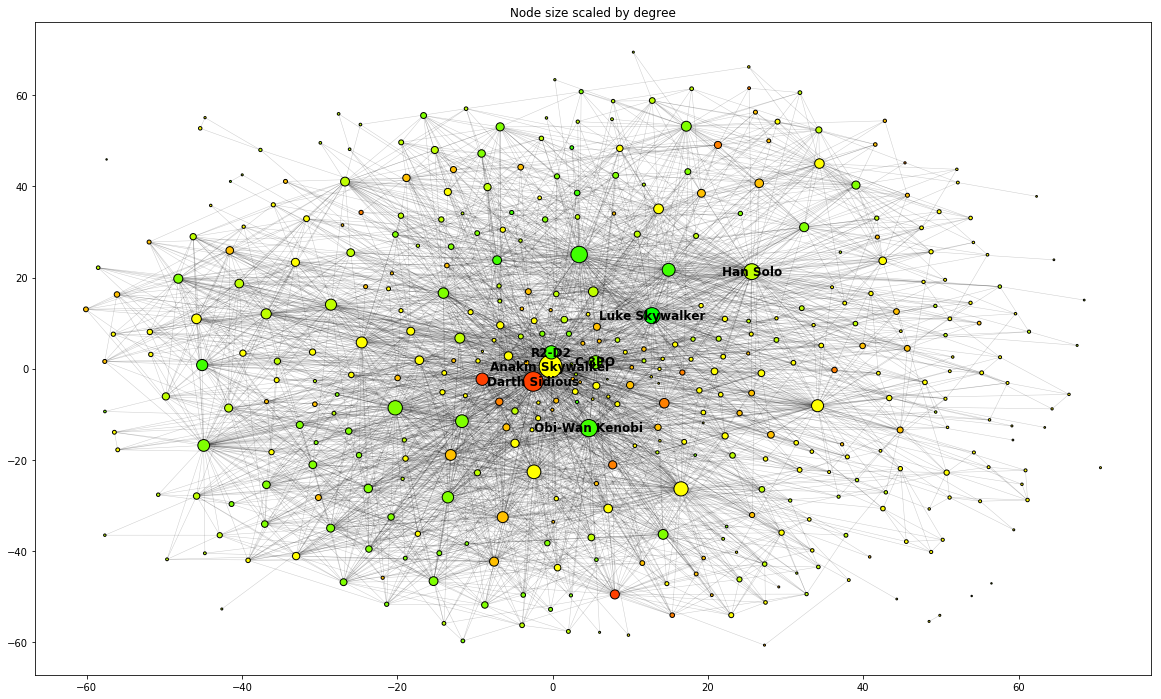

In [132]:
plt.figure(figsize=(20,12))
plt.title("Node size scaled by degree")

sizemap_degree = []
colormap = []
colors = ["red", "yellow", "green"]
red = 255
green = 0
stepSize = 64 
colorScale = []
while green < 255 :
    green += stepSize
    if green > 255 : 
        green = 255
    colorScale.append(('#%02x%02x%02x' % (red, green, 0)))

while(red > 0) :
    red -= stepSize
    if red < 0 :
        red = 0
    colorScale.append(('#%02x%02x%02x' % (red, green, 0)))


for node in G_undir:
    sizemap_degree.append(G.degree(node, weight="weight") + 2)
    idx = G.node[node]['goodness']+3
    colormap.append(colorScale[idx])

nodelist = [node for node in G_undir.nodes]
edgelist = [edge for edge in G_undir.edges]
nx.draw_networkx_nodes(G_undir, positions, with_labels=False, nodelist=nodelist, node_color=colormap, edgecolors="black", node_size=sizemap_degree)
nx.draw_networkx_edges(G_undir, positions, alpha=0.2, edge_color="black", width=0.5, edgelist=edgelist)


labelNodes = ["Anakin Skywalker", "Obi-Wan Kenobi", "R2-D2", "C-3PO", "Darth Sidious", "Luke Skywalker", "Han Solo"]
labels = {}
for node in nodelist :
    if node in labelNodes :
        labels[node] = node
    else :
        labels[node] = ""
            
nx.draw_networkx_labels(G_undir,pos=positions, labels = labels, font_color = "black", font_weight = "bold")
plt.show()

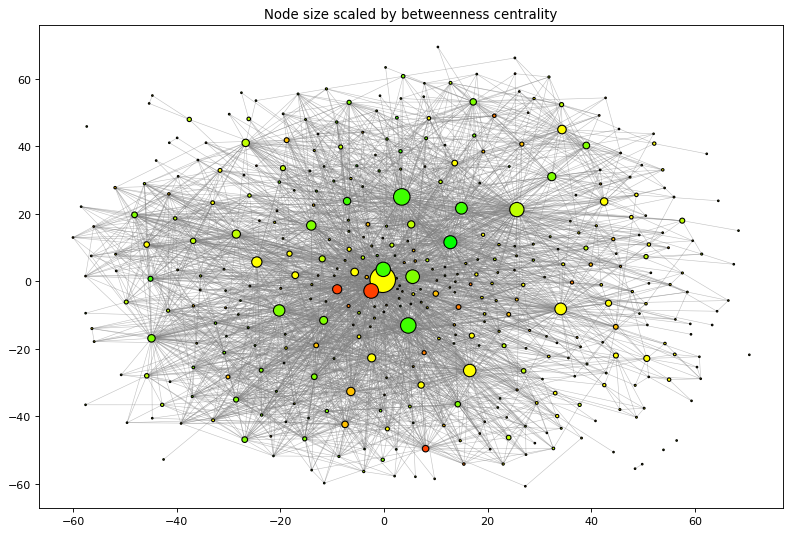

In [133]:
btw_cnt = nx.betweenness_centrality(G, weight="weight")

btw_cnt = list(map(lambda n: btw_cnt[n], nodelist))
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title("Node size scaled by betweenness centrality")
scale_node = 3000
nx.draw_networkx_nodes(G_undir, positions, with_labels=False, nodelist=nodelist,
                       node_color=colormap, edgecolors="black", node_size=list(map(lambda x: 2+x*scale_node, btw_cnt)) )
nx.draw_networkx_edges(G_undir, positions, edge_color="gray", alpha=0.5, width=0.5)

plt.show()

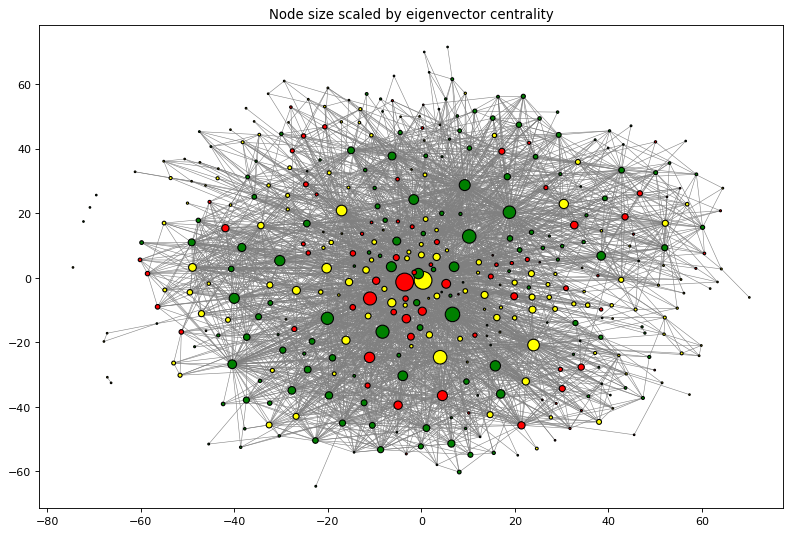

In [26]:
eig_cnt = nx.eigenvector_centrality(G, weight="weight")
eig_cnt = list(map(lambda n: eig_cnt[n], nodelist))

plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title("Node size scaled by eigenvector centrality")
scale_node = 700
nx.draw_networkx_nodes(G_undir, positions, with_labels=False, nodelist=nodelist, node_color=colormap,
                       edgecolors="black", node_size=list(map(lambda x: 2+x*scale_node, eig_cnt)) )
nx.draw_networkx_edges(G_undir, positions, edge_color="gray", width=0.5)

plt.show()

In [27]:
in_degrees = [G.in_degree(x) for x in G.nodes()]
out_degrees = [G.out_degree(x) for x in G.nodes()]
degrees = [G.degree(x) for x in G.nodes()]

degrees_names = sorted(G.nodes, key=lambda x: G.degree(x), reverse=True)
out_degrees_names = sorted(G.nodes, key=lambda x: G.out_degree(x), reverse=True)
in_degrees_names = sorted(G.nodes, key=lambda x: G.in_degree(x), reverse=True)
goodness_names = sorted (G.nodes, key=lambda x: G.node[x]['goodness'], reverse=True)
print(degrees_names[:5])

['Anakin Skywalker', 'Darth Sidious', 'Obi-Wan Kenobi', 'Leia Organa', 'Han Solo']


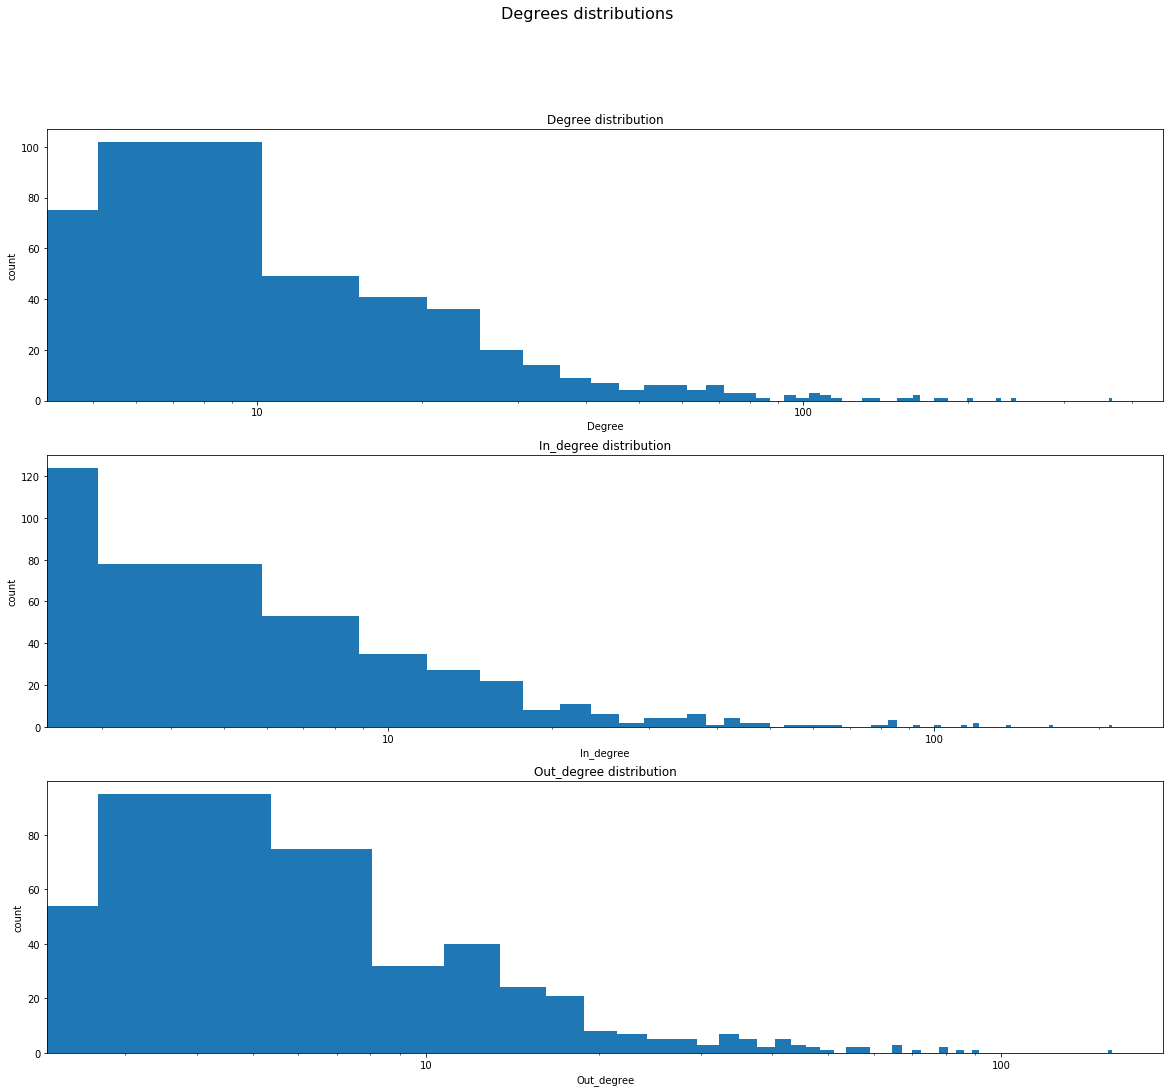

In [28]:
fig = plt.figure(figsize=(20,17))
fig.suptitle("Degrees distributions", fontsize=16)
ax = plt.subplot("311")
ax.set_title("Degree distribution")
ax.hist(degrees, bins='auto')
ax.set_ylabel("count")
ax.set_xlabel("Degree")
ax.set_xscale('log')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


ax = plt.subplot("312")
ax.set_title("In_degree distribution")
ax.hist(in_degrees, bins='auto')
ax.set_ylabel("count")
ax.set_xlabel("In_degree")
ax.set_xscale('log')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax = plt.subplot("313")
ax.set_title("Out_degree distribution")
ax.hist(out_degrees, bins='auto')
ax.set_ylabel("count")
ax.set_xlabel("Out_degree")
ax.set_xscale('log')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.show()

# Community Detection


In [29]:
from community import community_louvain

partition = community_louvain.best_partition(G_undir)
print
print("Value of modularity: %s" % community_louvain.modularity(partition, G_undir))


Value of modularity: 0.387232843704


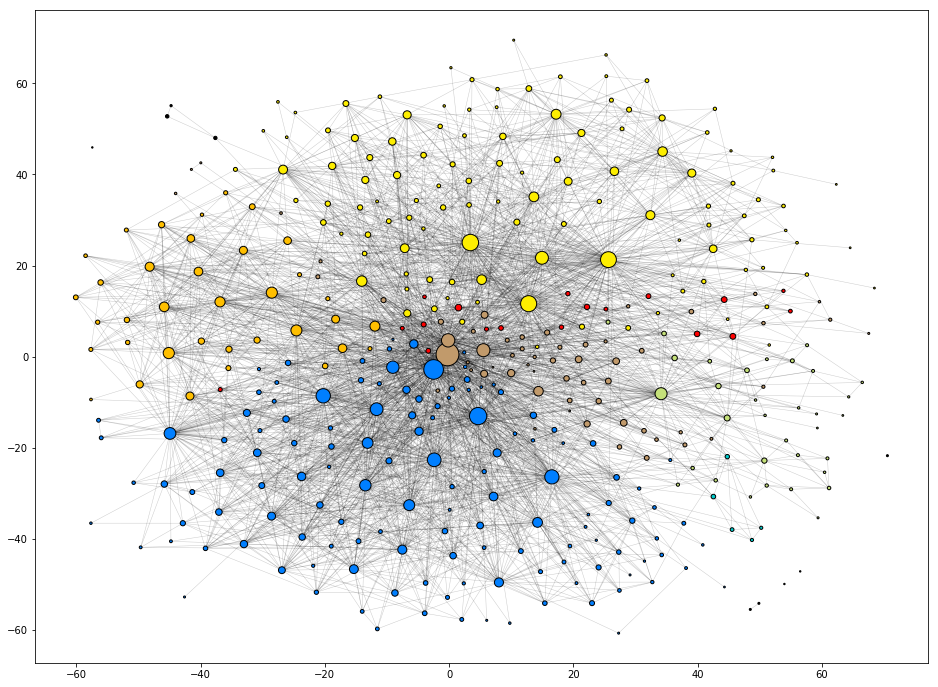

In [136]:
# We set the colors for each community
size = float(len(set(partition.values())))
communities = []
for com in set(partition.values()):
    list_nodes = [node for node in partition.keys()
                                if partition[node] == com]
    communities.append(list_nodes)
    
comDegrees = []
for com in communities :
    comDegreeSorted = sorted(com, key=lambda x: G.degree(x), reverse=True)
    comDegrees.append(comDegreeSorted)

communityDict = {}
communityDict["Episodes 1,2,3 and Clone Wars"] = comDegrees[0]
communityDict["Tatooine"] = comDegrees[1]
communityDict["Star Wars Rebels"] = comDegrees[2]
communityDict["Episodes 4,5,6,7,8"] = comDegrees[3]
communityDict["Rogue One and Solo"] = comDegrees[4]
communityDict["Jabbas Empire"] = comDegrees[5]
communityDict["Naberrie Family"] = comDegrees[7]    




import random
rColors = []
rColors.append("#007FFF")
rColors.append("#C19A6B")
rColors.append("#FFBF00")
rColors.append("#FDEE00")
rColors.append("#FF0000")
rColors.append("#C5E17A")
rColors.append("#000000")
rColors.append("#00CCCC")
rColors.append("#000000")
rColors.append("#000000")
rColors.append("#000000")
rColors.append("#000000")
rColors.append("#000000")
rColors.append("#000000")

colormap = []

for node in G_undir:
    for i in range(len(communities)):
        com = communities[i]
        if node in com:
            colormap.append(rColors[i])
            break
# Draw the network
plt.figure(1, figsize=(16, 12)) 
light_gray = '#d3d3d3'
nx.draw_networkx_nodes(G_undir, positions, with_labels=False, nodelist=nodelist, node_color=colormap, edgecolors="black", node_size=sizemap_degree)
nx.draw_networkx_edges(G_undir, positions, alpha=0.2, edge_color="black", width=0.5, edgelist=edgelist)

plt.show()

In [ ]:
print communityDict["Episodes 1,2,3 and Clone Wars"]
print communityDict["Tatooine"]
print communityDict["Star Wars Rebels"]
print communityDict["Episodes 4,5,6,7,8"]
print communityDict["Rogue One and Solo"]
print communityDict["Jabbas Empire"]
print communityDict["Naberrie Family"]

# Wordcloud over characters

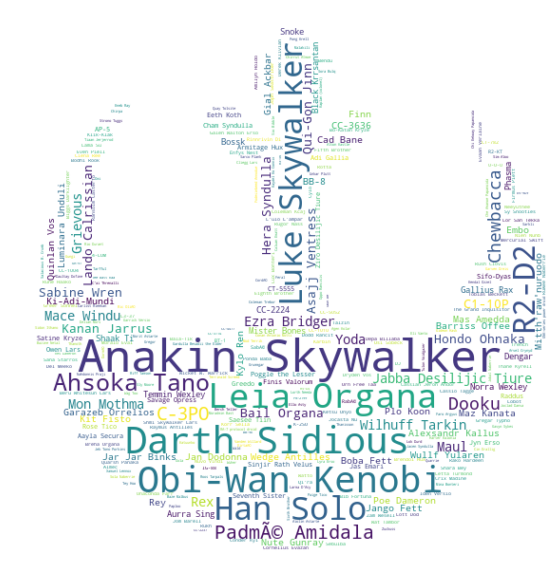

In [32]:
freqs = {}
for node in G:
    freqs[node] = G.degree(node) 
r2_mask = np.array(Image.open('./Transcripts/rebel.png', 'r'))
wordcloud = WordCloud(background_color="white", max_words=2000, mask=r2_mask)

wordcloud.generate_from_frequencies(freqs)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Wordcloud over communities


In [145]:
#print communityDict["Episodes 1,2,3 and Clone Wars"]
#print communityDict["Tatooine"]
#print communityDict["Star Wars Rebels"]
#print communityDict["Episodes 4,5,6,7,8"]
#print communityDict["Rogue One and Solo"]
#print communityDict["Jabbas Empire"]
#print communityDict["Naberrie Family"]

['Ruwee Naberrie', 'Sola Naberrie', 'Jobal Naberrie', 'Pooja Naberrie', 'Ryoo Naberrie']


In [146]:
com0 = ["Darth Sidious","Obi-Wan Kenobi",'Ahsoka Tano','Padmé Amidala','Dooku','Yoda','Maul','Mace Windu','Grievous','Jar Jar Binks','Nute Gunray']
com1 = ['Anakin Skywalker', 'R2-D2', 'C-3PO', 'Boba Fett','Bossk','Owen Lars', 'Shmi Skywalker Lars','Beru Whitesun Lars']
com2 = ['Wilhuff Tarkin', 'Ezra Bridger', 'Kanan Jarrus', 'Hera Syndulla', 'Sabine Wren', 'C1-10P','Garazeb Orrelios', 'Alexsandr Kallus']
com3 = ['Leia Organa', 'Han Solo', 'Luke Skywalker', 'Chewbacca', 'Mon Mothma', 'Lando Calrissian', 'Wedge Antilles', 'Poe Dameron', 'Gial Ackbar', 'Finn', 'Kylo Ren', 'Rey', 'BB-8']
com4 = ['Jyn Erso', "Qi'ra", 'Dryden Vos', 'Tobias Beckett', 'Galen Walton Erso','Cassian Jeron Andor', 'K-2SO','Bodhi Rook', 'Enfys Nest']
com5 = ['Jabba Desilijic Tiure', 'Greedo', 'Sy Snootles','Bib Fortuna','Salacious B. Crumb', 'Oola']
com6 = ['Ruwee Naberrie', 'Sola Naberrie', 'Jobal Naberrie', 'Pooja Naberrie', 'Ryoo Naberrie']


# Sentiment for wikipage based on races


In [151]:
species = {}
for node in G.nodes :
    spe = G.nodes[node]["species"]
    if spe in species :
        species[spe].append(node)
    else :
        species[spe] = [node]
       

In [157]:
def tokenize(text):
    text = text.decode('ascii','ignore')

    # Remove all punctuation and numbers
    regexp = '[^\W]+'
    cleanTokens = re.findall(regexp, text)
    
    # Remove all words of length 1 and set lowercase
    cleanTokens = [w.lower() for w in cleanTokens if len(w) > 1]
    stopwords = nltk.corpus.stopwords.words('english')

    # Remove stopwords
    cleanTokens = [w for w in cleanTokens if w not in stopwords]
    
    return cleanTokens

def read_file(filename):
    with io.open('./'+filename, encoding='utf-8') as f:
        return f.read()

# Read word list and extract all the various categories
mt_word_list = read_file('Sentiment_Data_Set_S1.txt').splitlines()[3:]
sentiment_dict = {}

# Iterating over every word in list
for row in mt_word_list[1:]:
    cols = row.split("\t")
    word = cols[0]
    # cols[2] is the happiness score avg.
    sentiment_dict[word] = cols[2]

def get_sentiment(tokens):
    sentiment_sum = 0.0
    count = 0
    for token in tokens:
        if token in sentiment_dict:
            sentiment_sum += float(sentiment_dict[token]) # happiness avg
            count += 1
    if count == 0:
        return None
    avg_hap = sentiment_sum / float(count)
    return avg_hap

In [162]:
speciesSentiment = {}
for spe in species.keys() :
    speciesSentiment[spe] = 0
    for name in species[spe]:
        fileName = name.replace(" ", "_") + ".txt"
        text = open("./Wookiepediafiles/" + fileName, "r").read()
        speciesSentiment[spe] += get_sentiment(tokenize(text))
    speciesSentiment[spe] = speciesSentiment[spe]/len(species[spe]) 

    
sortedSentiment = sorted(speciesSentiment.items(), key=lambda kv: kv[1])
print sortedSentiment

[('gossam', 5.0815312500000065), ('clantaani', 5.0861450381679445), ('iktotchi', 5.125076560659592), ('karkarodon', 5.134096834264427), ('faust', 5.147757009345796), ('muun', 5.168989637305709), ('ongree', 5.178477645727224), ('kaleesh', 5.197194971653933), ('togruta', 5.22431269982588), ('zygerrian', 5.225844594594594), ('vurk', 5.232271293375399), ('cloddogran', 5.232857142857144), ('kel dor', 5.233534696406437), ('mirialan', 5.240149735003062), ('robot: power droid', 5.2406824925816125), ('robot: service droid', 5.243327171903881), ('noghri', 5.244156378600817), ('trandoshan', 5.244465875370895), ('weequay', 5.245682915345067), ('thisspiasian', 5.246467463479418), ('cerean', 5.247166291411996), ('robot: smelter droid', 5.2475210084033685), ('harch', 5.253066322136092), ('nikto', 5.255931544380858), ('clawdite', 5.2587041564792285), ('skakoan', 5.261045130641319), ('geonosian', 5.263860195172057), ('phindian', 5.263975975975979), ('tholothian', 5.266930294906171), ('kiffar', 5.267320